# Применение логистической регрессии для решения задачи классификации

# Описание набора данных

Данный набор содержит информацию о пассажирах корабля «Титаник», затонувшего в ночь на 15-е апреля 1912 года. Некоторое количество пассажиров спаслось, чему способствовало множество различных факторов, включая их пол, возраст, на какой палубе находилась их кабина, социальный статус, и т.д.

Набор данных состоит из различных признаков, описывающих информацию о пассажирах. Каждая строка таблицы — отдельный пассажир, вся информация о нем содержится в его строке.

Описание датасета:
- **Survived** (целевой признак): выжил ли пассажир (0 = Нет, 1 = Да);
- **Pclass**: класс каюты (1 = 1st, 2 = 2nd, 3 = 3rd);
- **Sex**: пол (female или male)
- **Age**: возраст в годах
- **SibSp**: количество братьев, сестёр (в том числе сводных) и супругов на борту
- **Parch**: количество детей и родителей на борту
- **Ticket**: номер билета
- **Fare**: стоимость проезда пассажира
- **Cabin**: номер каюты
- **Embarked**: порт посадки пассажира (C = Cherbourg, Q = Queenstown, S = Southampton).

Необходимо решить задачу классификации и научиться предсказывать целовой признак **Survived** — выживет ли пассажир — по соответсвующим ему нецелевым признакам.


# Подготовка и первичный анализ данных

In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [119]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [120]:
df = pd.read_csv('/content/drive/MyDrive/DeepLearningCourse/titanic_train.csv')

In [121]:
df

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,3,1,"Smyth, Miss. Julia",female,NaN,0,0,335432,7.7333,NaN,Q,NaN
1,3,1,"Glynn, Miss. Mary Agatha",female,NaN,0,0,335677,7.7500,NaN,Q,"Co Clare, Ireland Washington, DC"
2,3,1,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,0,0,2688,7.2292,NaN,C,NaN
3,3,0,"Vovk, Mr. Janko",male,22.0,0,0,349252,7.8958,NaN,S,NaN
4,3,0,"de Pelsmaeker, Mr. Alfons",male,16.0,0,0,345778,9.5000,NaN,S,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
976,3,1,"Howard, Miss. May Elizabeth",female,NaN,0,0,A. 2. 39186,8.0500,NaN,S,NaN
977,3,1,"Dorking, Mr. Edward Arthur",male,19.0,0,0,A/5. 10482,8.0500,NaN,S,"England Oglesby, IL"
978,2,0,"Gillespie, Mr. William Henry",male,34.0,0,0,12233,13.0000,NaN,S,"Vancouver, BC"
979,3,0,"Barton, Mr. David John",male,22.0,0,0,324669,8.0500,NaN,S,"England New York, NY"


Установите количество пропущенных значений поля <code>age</code>:

In [122]:
df['age'].isna().sum()

199

Определите долю выживших

In [123]:
round(df['survived'].sum() / df.shape[0], 3)

0.382

Определите долю пропущенных значений в рамках каждого признака и избавьтесь от тех признаков, где доля пропусков больше трети. Также удалите колонку <code>ticket</code>, вряд ли эта информация будет полезной.

In [124]:
df = df.loc[:, df.columns != 'ticket']

edited_df = pd.DataFrame()
rows_num = df.shape[0] / 3

for col in df.columns:
  if df[col].isna().sum() <= rows_num:
    edited_df[col] = df[col]

edited_df

,pclass,survived,name,sex,age,sibsp,parch,fare,embarked
0,3,1,"Smyth, Miss. Julia",female,NaN,0,0,7.7333,Q
1,3,1,"Glynn, Miss. Mary Agatha",female,NaN,0,0,7.7500,Q
2,3,1,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,0,0,7.2292,C
3,3,0,"Vovk, Mr. Janko",male,22.0,0,0,7.8958,S
4,3,0,"de Pelsmaeker, Mr. Alfons",male,16.0,0,0,9.5000,S
...,...,...,...,...,...,...,...,...,...
976,3,1,"Howard, Miss. May Elizabeth",female,NaN,0,0,8.0500,S
977,3,1,"Dorking, Mr. Edward Arthur",male,19.0,0,0,8.0500,S
978,2,0,"Gillespie, Mr. William Henry",male,34.0,0,0,13.0000,S
979,3,0,"Barton, Mr. David John",male,22.0,0,0,8.0500,S


Из описания набора данных видно, что колонки <code>sibsp</code> и <code>parch</code> по сути отвечают за размер семьи. Замените эти две колонки на колонку <code>fam_size</code>, значения которой будут вычисляться как сумма соответствующих значений в колонках <code>sibsp</code> и <code>parch</code>.

In [125]:
edited_df['fam_size'] = edited_df['sibsp'] + edited_df['parch']

edited_df = edited_df.loc[:, edited_df.columns != 'sibsp']
edited_df = edited_df.loc[:, edited_df.columns != 'parch']

In [126]:
round(edited_df['fam_size'].mean(), 3)

0.866

Полученный датасет будем называть **исходным** (выброшенные на этом этапе признаки не нужно возвращать ни на одном из последующих этапов выполнения задания). Вычислите полученное число предикторов.

In [127]:
edited_df.shape[1] - 1

7

In [128]:
edited_df

,pclass,survived,name,sex,age,fare,embarked,fam_size
0,3,1,"Smyth, Miss. Julia",female,NaN,7.7333,Q,0
1,3,1,"Glynn, Miss. Mary Agatha",female,NaN,7.7500,Q,0
2,3,1,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,7.2292,C,0
3,3,0,"Vovk, Mr. Janko",male,22.0,7.8958,S,0
4,3,0,"de Pelsmaeker, Mr. Alfons",male,16.0,9.5000,S,0
...,...,...,...,...,...,...,...,...
976,3,1,"Howard, Miss. May Elizabeth",female,NaN,8.0500,S,0
977,3,1,"Dorking, Mr. Edward Arthur",male,19.0,8.0500,S,0
978,2,0,"Gillespie, Mr. William Henry",male,34.0,13.0000,S,0
979,3,0,"Barton, Mr. David John",male,22.0,8.0500,S,0


На основе имеющейся статистики оцените вероятность выжить если пассажир -- представитель определенной категории (указана в вашем индивидуальном задании)

In [129]:
pclass_condition = 3
sex_condition = 'male'
target_value = 1

# Фильтруем данные по условиям
filtered_df = edited_df[(edited_df['pclass'] == pclass_condition) & (edited_df['sex'] == sex_condition)]

# Считаем количество значений target_value в столбце 'survived'
target_count = (filtered_df['survived'] == target_value).sum()

# Считаем общее количество строк, соответствующих условиям
total_count = len(filtered_df)

round(target_count / total_count, 3)

0.164

Постройте гистограммы выжиших и невыживших по возрастам.

In [130]:
survivals_age = edited_df[edited_df['survived'] == 1]['age'].dropna()
death_age = edited_df[edited_df['survived'] == 0]['age'].dropna()

In [131]:
def step_counter(max_age):
  step = max_age // 15
  if (max_age % 15) == 0:
    return step
  return step + 1

In [132]:
s_step = step_counter(max(survivals_age))
d_step = step_counter(max(death_age))

In [133]:
if (max(survivals_age) % s_step) == 0:
  s_stop = max(survivals_age)
else:
  s_stop = s_step * (max(survivals_age) // s_step + 1)

if (max(death_age) % d_step) == 0:
  d_stop = max(death_age)
else:
  d_stop = d_step * (max(death_age) // d_step + 1)

In [134]:
survivals_edges = np.arange(start=0, stop=s_stop, step=s_step)
death_edges = np.arange(start=0, stop=d_stop, step=d_step)

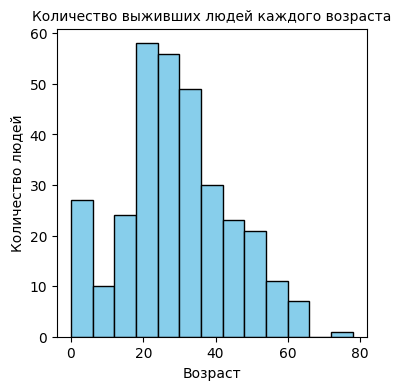

In [135]:
plt.figure(figsize=(4, 4))
plt.hist(edited_df[edited_df['survived'] == 1]['age'].to_numpy(), bins=survivals_edges, edgecolor='black', color='skyblue')
plt.title('Количество выживших людей каждого возраста', fontsize=10)
plt.xlabel('Возраст', fontsize=10)
plt.ylabel('Количество людей', fontsize=10)
plt.show()

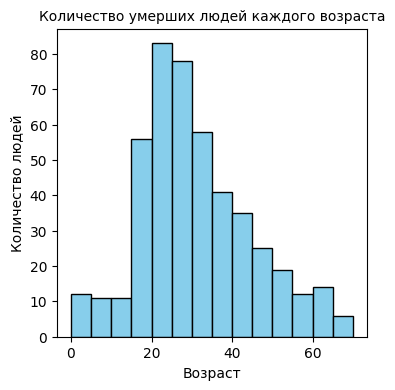

In [136]:
plt.figure(figsize=(4, 4))
plt.hist(edited_df[edited_df['survived'] == 0]['age'].to_numpy(), bins=death_edges, edgecolor='black', color='skyblue')
plt.title('Количество умерших людей каждого возраста', fontsize=10)
plt.xlabel('Возраст', fontsize=10)
plt.ylabel('Количество людей', fontsize=10)
plt.show()

# Модель на основе числовых признаков

## Удаление строк с пропусками

В качестве базовой модели имеет смысл построить модель с минимальными трудозатратами.

Из исходного датасета удалите все категориальные признаки, а также строки, содержащие пропуски.

При помощи <code>train_test_split()</code> разбейте набор данных на обучающую и тестовую выборки<b> с параметрами, указанными в вашем задании</b>. Используйте стратификацию по колонке <code>survived</code>.

Обучите модель <code>LogisticRegression()</code> <b>с параметрами, указанными в вашем задании</b>, на тренировочных данных, оцените на тестовых.

Вычислите <code>f1_score</code> модели на тестовых данных (рекомендуем использовать <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html">соответствующую функцию</a> с параметрами по умолчанию.



In [137]:
df_cleaned = edited_df.select_dtypes(exclude=['object', 'category']).dropna()

In [138]:
survived_col = df_cleaned['survived']

In [139]:
df_cleaned = df_cleaned.loc[:, (df_cleaned.columns != 'survived')]

In [140]:
x_train, x_test, y_train, y_test = train_test_split(df_cleaned,
                                                    survived_col,
                                                    test_size=0.2,
                                                    random_state=21,
                                                    stratify=survived_col)

In [141]:
log_reg = LogisticRegression(random_state=21, max_iter=1000).fit(x_train, y_train)

In [142]:
round(f1_score(y_test, log_reg.predict(x_test)), 3)

0.566

In [143]:
edited_df

,pclass,survived,name,sex,age,fare,embarked,fam_size
0,3,1,"Smyth, Miss. Julia",female,NaN,7.7333,Q,0
1,3,1,"Glynn, Miss. Mary Agatha",female,NaN,7.7500,Q,0
2,3,1,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,7.2292,C,0
3,3,0,"Vovk, Mr. Janko",male,22.0,7.8958,S,0
4,3,0,"de Pelsmaeker, Mr. Alfons",male,16.0,9.5000,S,0
...,...,...,...,...,...,...,...,...
976,3,1,"Howard, Miss. May Elizabeth",female,NaN,8.0500,S,0
977,3,1,"Dorking, Mr. Edward Arthur",male,19.0,8.0500,S,0
978,2,0,"Gillespie, Mr. William Henry",male,34.0,13.0000,S,0
979,3,0,"Barton, Mr. David John",male,22.0,8.0500,S,0


In [144]:
df_cleaned

,pclass,age,fare,fam_size
2,3,38.0,7.2292,0
3,3,22.0,7.8958,0
4,3,16.0,9.5000,0
5,3,29.0,7.7500,0
7,1,25.0,26.0000,0
...,...,...,...,...
975,2,19.0,10.5000,0
977,3,19.0,8.0500,0
978,2,34.0,13.0000,0
979,3,22.0,8.0500,0


## Заполнение пропусков средним

Качество полученной модели оставляет желать лучшего. Имеет смысл попробовать заполнить пропуски. Из исходного набора данных удалите категориальные признаки, а пропуски заполните средним по столбцу. Далее аналогично: разделение, обучение, оценка.

Вычислите <code>f1_score</code> модели на тестовых данных

In [145]:
df_filled = edited_df.select_dtypes(exclude=['object', 'category'])
df_filled = df_filled.loc[:, (df_filled.columns != 'survived')]
df_filled['age'] = df_filled['age'].fillna(df_filled['age'].mean())
df_filled['fam_size'] = df_filled['fam_size'].fillna(df_filled['fam_size'].mean())
df_filled['fare'] = df_filled['fare'].fillna(df_filled['fare'].mean())

In [146]:
x_train, x_test, y_train, y_test = train_test_split(df_filled,
                                                    edited_df['survived'],
                                                    test_size=0.2,
                                                    random_state=21,
                                                    stratify=edited_df['survived'])

In [147]:
log_reg = LogisticRegression(random_state=21, max_iter=1000).fit(x_train, y_train)

In [148]:
round(f1_score(y_test, log_reg.predict(x_test)), 3)

0.476

## Заполнение пропусков на основе обращения


Очевидно, что заполнение пропусков в колонке <code>age</code> средним — не самая разумная идея. Возможно, стоит выполнить эту процедуру как-то более интеллектуально, например, с оглядкой на обращение к человеку.

Можно заметить, что исходный датасет в столбце <code>name</code> содержит информацию о социальном статусе пассажира, а именно присутсвуют обращения <code>Mr., Mrs., Dr.</code> и т.д. На основе этой информации можно попробовать сделать предположение о возрасте пассажира.

Верните в рассмотрение колонку <code>name</code>. Создайте отдельную колонку <code>honorific</code> и поместите туда значения обращений.

Вычислите число уникальных обращений.

In [149]:
edited_df['honorific'] = list(edited_df['name'].str.extract('([A-Za-z]+)\.')[0])

In [150]:
print('Число уникальных honorific: ', len(edited_df['honorific'].unique()))
edited_df['honorific'].unique()

Число уникальных honorific:  14


array(['Miss', 'Mrs', 'Mr', 'Master', 'Mlle', 'Rev', 'Ms', 'Col', 'Dona',
       'Dr', 'Countess', 'Major', 'Don', 'Capt'], dtype=object)

Скорее всего имеет смысл сократить число обращений, добавив малочисленные группы к более многочисленным, так как принципиальной разницы между, например, <code>Don</code> и <code>Mr</code>, видимо, нет. Отметим, что <code>Master</code> — это прежнее обращение к ребенку, с этим обращением будем работать отдельно.




Выполните следующие замены:

<code>Mr</code> $\leftarrow$ <code>['Rev', 'Col', 'Dr', 'Major', 'Don', 'Capt']</code>

<code>Mrs</code> $\leftarrow$ <code> ['Dona', 'Countess']</code>

<code>Miss</code> $\leftarrow$ <code> ['Mlle', 'Ms']</code>

In [151]:
edited_df['honorific'].\
replace(['Mlle', 'Rev', 'Ms' ,  'Col', 'Dona', 'Dr', 'Countess', 'Major', 'Don', 'Capt'],\
        ['Miss', 'Mr' , 'Miss', 'Mr' ,  'Mrs' ,  'Mr',    'Mrs'  ,  'Mr',  'Mr',  'Mr' ], inplace=True)

<ipython-input-151-e24c3a449a0e>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  edited_df['honorific'].\


In [152]:
edited_df['honorific'].unique()

array(['Miss', 'Mrs', 'Mr', 'Master'], dtype=object)

Вычислите долю строк со значением <code>Master</code> относительно числа всех мужчин

In [153]:
print('Master_rate', round(len(edited_df[edited_df['honorific']=='Master'])/len(edited_df[edited_df['sex']=='male']), 3))

Master_rate 0.072


Вычислите средний возраст категории, указанной в вашем индивидуальном задании

In [154]:
age_dict = dict(edited_df.groupby('honorific')['age'].mean())

In [155]:
age_dict

{'Master': 5.128205128205129,
 'Miss': 22.005765408805033,
 'Mr': 32.90043763676149,
 'Mrs': 36.98425196850393}

Заполните пропуски в колонке <code>age</code> средним, соответствующим среднему категории <code>honorific</code>.

Избавьтесь от нечисловых признаков. Далее аналогично: разделение, обучение, оценка.

Вычислите <code>f1_score</code> модели на тестовых данных

In [156]:
df_with_hmeans = edited_df.copy()
df_with_hmeans.loc[(df_with_hmeans['age'].isna()) & (df_with_hmeans['honorific'] == 'Master'), 'age'] = age_dict['Master']
df_with_hmeans.loc[(df_with_hmeans['age'].isna()) & (df_with_hmeans['honorific'] == 'Miss'), 'age'] = age_dict['Miss']
df_with_hmeans.loc[(df_with_hmeans['age'].isna()) & (df_with_hmeans['honorific'] == 'Mr'), 'age'] = age_dict['Mr']
df_with_hmeans.loc[(df_with_hmeans['age'].isna()) & (df_with_hmeans['honorific'] == 'Mrs'), 'age'] = age_dict['Mrs']

In [157]:
df_with_hmeans = df_with_hmeans.select_dtypes(exclude=['object', 'category'])
df_with_hmeans = df_with_hmeans.loc[:, (df_with_hmeans.columns != 'survived')]

In [158]:
df_with_hmeans

,pclass,age,fare,fam_size
0,3,22.005765,7.7333,0
1,3,22.005765,7.7500,0
2,3,38.000000,7.2292,0
3,3,22.000000,7.8958,0
4,3,16.000000,9.5000,0
...,...,...,...,...
976,3,22.005765,8.0500,0
977,3,19.000000,8.0500,0
978,2,34.000000,13.0000,0
979,3,22.000000,8.0500,0


In [159]:
x_train, x_test, y_train, y_test = train_test_split(df_with_hmeans,
                                                    edited_df['survived'],
                                                    test_size=0.2,
                                                    random_state=21,
                                                    stratify=edited_df['survived'])

In [160]:
log_reg = LogisticRegression(random_state=21, max_iter=1000).fit(x_train, y_train)

In [161]:
round(f1_score(y_test, log_reg.predict(x_test)), 3)

0.488

# Модель с использование категориальных признаков

В исходном наборе данных заполните пропуски колонки <code>age</code> значениями на основе обращений (как в предыдущем пункте).

Не используйте признаки <code>name</code> и <code>honorific</code>. Они свою функцию выполнили.

Произведите <code>one-hot</code> кодировние нечисловых признаков, например, с помощью <code>pd.get_dummies(drop_first=True)</code>. Далее по знакомой схеме: разделение, обучение, оценка.

Вычислите <code>f1_score</code> модели на тестовых данных

In [162]:
df_with_hmeans = edited_df.copy()
df_with_hmeans.loc[(df_with_hmeans['age'].isna()) & (df_with_hmeans['honorific'] == 'Master'), 'age'] = age_dict['Master']
df_with_hmeans.loc[(df_with_hmeans['age'].isna()) & (df_with_hmeans['honorific'] == 'Miss'), 'age'] = age_dict['Miss']
df_with_hmeans.loc[(df_with_hmeans['age'].isna()) & (df_with_hmeans['honorific'] == 'Mr'), 'age'] = age_dict['Mr']
df_with_hmeans.loc[(df_with_hmeans['age'].isna()) & (df_with_hmeans['honorific'] == 'Mrs'), 'age'] = age_dict['Mrs']

In [163]:
df_with_hmeans = df_with_hmeans.drop(columns=['name', 'honorific', 'survived'])
df_with_hmeans = pd.get_dummies(df_with_hmeans, drop_first=True)

In [164]:
x_train, x_test, y_train, y_test = train_test_split(df_with_hmeans,
                                                    edited_df['survived'],
                                                    test_size=0.2,
                                                    random_state=21,
                                                    stratify=edited_df['survived'])

In [165]:
log_reg = LogisticRegression(random_state=41, max_iter=1000).fit(x_train, y_train)

In [166]:
round(f1_score(y_test, log_reg.predict(x_test)), 3)

0.735